In [59]:
%matplotlib inline
import xarray as xr
import numpy as np
from time import time
import pickle
import statsmodels.api as sm

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

path_ = '/home/mizu_home/xp53/nas/BEST/TAVG/'
pre_ = 'Complete_TAVG_Daily_LatLong1_'

In [2]:

months = [1, 2, 3, 11, 12]
years = np.arange(1980, 2020, 10)
data = []
for yy in years:
    file_ = path_ + pre_ + str(yy) + '.nc'
    with xr.open_dataset(file_) as ds:
        t1 = time()
        for dy in range(10):
            for mm in months:
                if mm == 2:
                    filter_ds = ds.where((ds.latitude > 0) & (ds.year == yy + dy) & (ds.month == mm) & (ds.day != 29), drop=True)
                else:
                    filter_ds = ds.where((ds.latitude > 0) & (ds.year == yy + dy) & (ds.month == mm), drop=True)
                data.append(filter_ds.temperature)
        print('Time taken for year ', yy, ' is ', time() - t1)
    
concatenated_data = xr.concat(data, dim='time')
temp = concatenated_data.values
output = open('NH_winter_temp.pkl', 'wb')
pickle.dump(temp, output)
output.close()



Time taken for year  1980  is  61.6499080657959
Time taken for year  1990  is  63.269122838974
Time taken for year  2000  is  62.71376061439514
Time taken for year  2010  is  64.26490092277527


In [54]:
pkl_file = open('NH_winter_temp.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)[90:-61, :, :]

temp_mean = np.zeros((39, 90, 360))
temp_median = np.zeros((39, 90, 360))
for yy in range(39):
    left, right = yy*151, (yy+1)*151
    tmean = np.mean(temp[left:right, :, :], axis=0)
    tmedian = np.median(temp[left:right, :, :], axis=0)
    temp_mean[yy, :, :] = tmean
    temp_median[yy, :, :] = tmedian

mask = 1 - np.isnan(np.mean(temp_mean, axis=0))



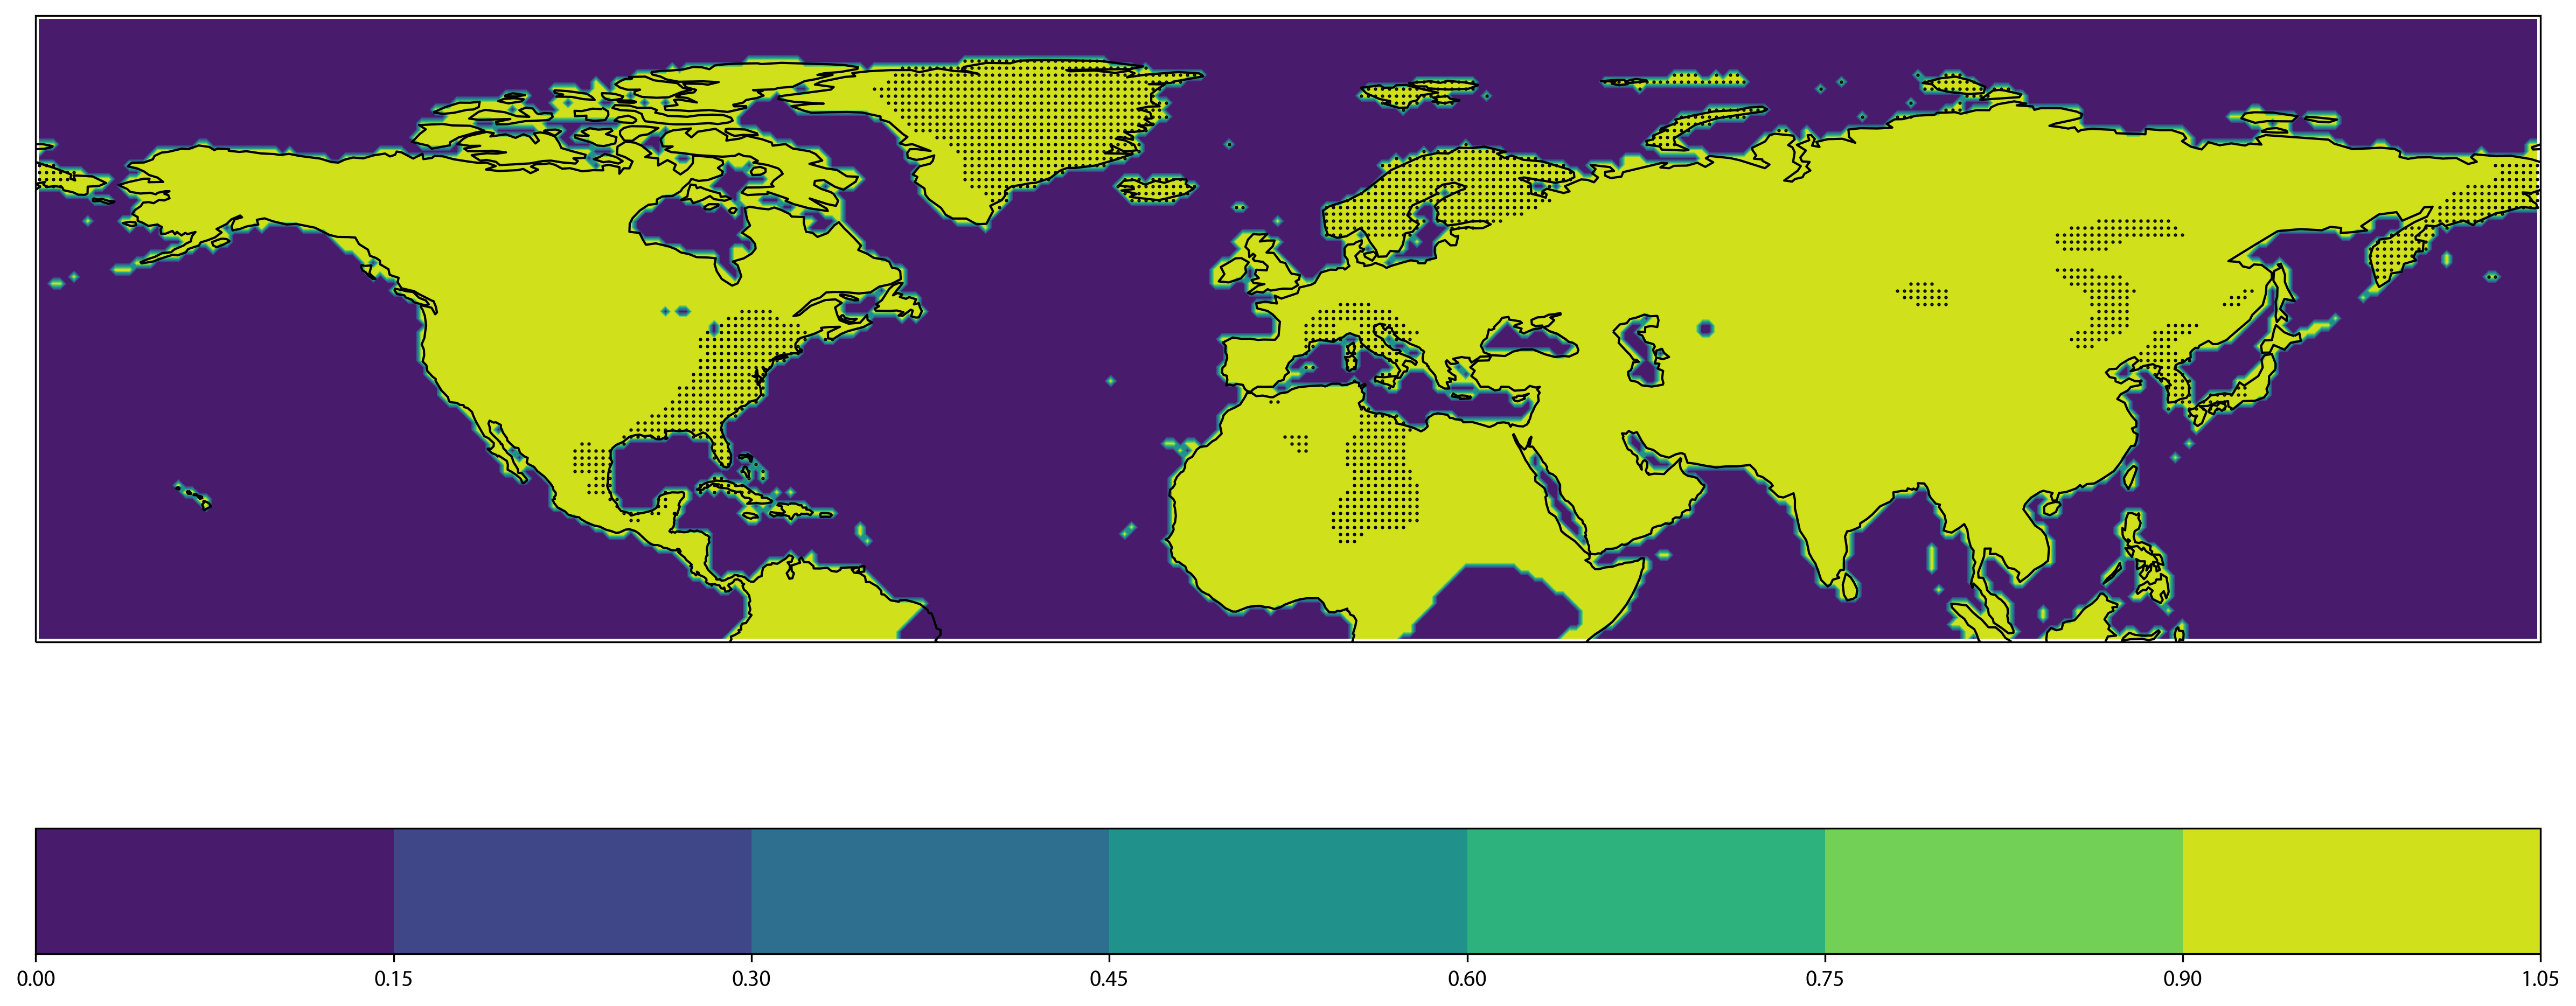

In [55]:
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
ax.coastlines()
basemap = ax.contourf(lon, lat, mask, transform=ccrs.PlateCarree())
# add colorbar
cbar = plt.colorbar(basemap, ax=ax, orientation='horizontal')
# add dots for grids with temperature less than 0 
lons, lats = np.meshgrid(lon, lat)
lons = lons[temp_mean[0, :, :] < -1]
lats = lats[temp_mean[0, :, :] < -1]
ax.scatter(lons, lats, color='black', marker='.', s=1)

# plt.show()


In [67]:
k_mean = np.zeros((90, 360))
k_median = np.zeros((90, 360))
pv_mean = np.zeros((90, 360))
pv_median = np.zeros((90, 360))

xx = np.arange(39)
xx = sm.add_constant(xx)

cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        
        if not mask[i, j]:
            continue
        
        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)

        lm1 = sm.OLS(temp_mean[:, i, j], xx).fit()
        k_mean[i, j] = lm1.params[1] * 10 # multiply by 10 to get the trend per decade
        pv_mean[i, j] = lm1.pvalues[1]

        lm2 = sm.OLS(temp_median[:, i, j], xx).fit()
        k_median[i, j] = lm2.params[1] * 10
        pv_median[i, j] = lm2.pvalues[1]
        

Processing  100  grids. Time taken so far:  0.000560760498046875
Processing  300  grids. Time taken so far:  0.0849602222442627
Processing  1000  grids. Time taken so far:  0.19949674606323242
Processing  1200  grids. Time taken so far:  0.23161983489990234
Processing  2000  grids. Time taken so far:  0.3922119140625
Processing  2100  grids. Time taken so far:  0.41356372833251953
Processing  2700  grids. Time taken so far:  0.532921314239502
Processing  2800  grids. Time taken so far:  0.5732808113098145
Processing  3000  grids. Time taken so far:  0.6040298938751221
Processing  3100  grids. Time taken so far:  0.6462676525115967
Processing  3500  grids. Time taken so far:  0.7601697444915771
Processing  3800  grids. Time taken so far:  0.8282010555267334
Processing  3900  grids. Time taken so far:  0.8673832416534424
Processing  4500  grids. Time taken so far:  0.9976963996887207
Processing  4600  grids. Time taken so far:  1.056335210800171
Processing  4900  grids. Time taken so far

KeyboardInterrupt: 